In [105]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

import community as community_louvain

In [106]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [108]:
data = r'data/wilco_edgelist.csv'

df = pd.read_csv(data)

df.head()

,source,target
0,wilco,Wilco
1,wilco,Procedure word
2,wilco,Roger Wilco
3,wilco,Wilco (disambiguation)
4,wilco,Jeff Tweedy


In [111]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

# use the ego network as the graph (to quickly remove noise) and radius to get to the right place
G = nx.ego_graph(G, 'Wilco', radius=2)

In [112]:
print(nx.info(G))

Graph with 166 nodes and 377 edges


# Music Discovery using Graph Analysis

In today's analysis, I am looking to discover other musicians and albums I was not aware of. I am a big fan of Wilco, but I stopped keeping up with albums after 2012, so this is my attempt at playing catch-up.

But this follows the larger theme of using networks for knowledge discovery, or information discovery, whatever you want to call it. 

Often, graphs are used as a source of data, but not explored. There are rich insights in any networks, but you must explore. 

# Inspect the Core

One of the first things I always do is inspect the core. It can be useful to do an inspection of the core of any network, to see the different parts that are influencing the network. To do this, I use k_core, and I increase the number until I can go no higher. 

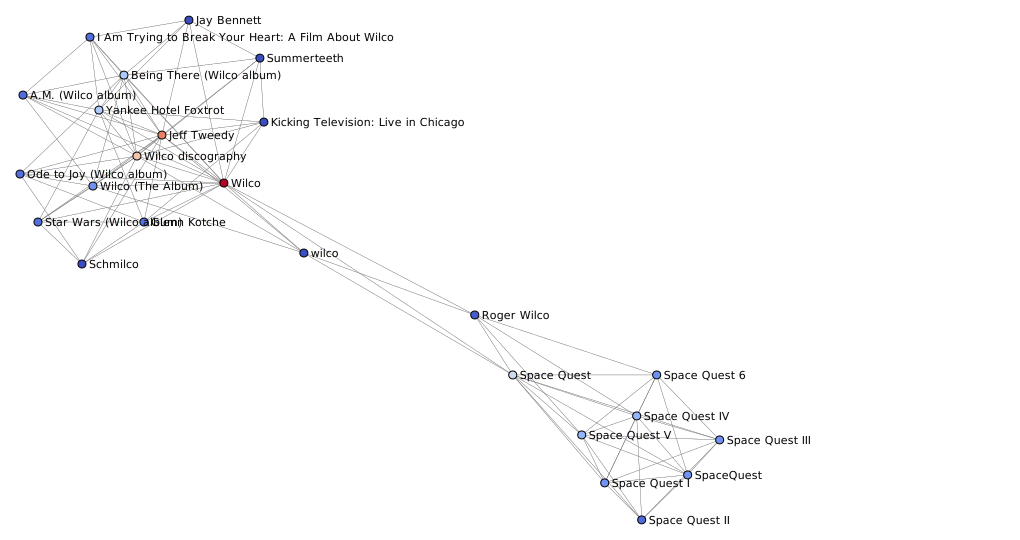

In [54]:
# draw the core

draw_graph(nx.k_core(G, 6), node_size=4, font_size=11, show_names=True, edge_width=0.3)

Now I can see that there are a few parts to this network and that it is not a pure Wilco network. That's normal when using automation to generate network data. It takes exploration to get to the value. Get used to zooming in and out using k_core. It is very useful for this. 

# Identify Nodes of Interest

The next thing I do is identify key nodes of interest. As written about previously, there are ceveral measures and centralities that can be used, such as Page Rank, Betweenness Centrality, Degree Centrality, Closeness Centrality, and on and on. Spend time learning about the different measures of importance. There are very useful.

In [55]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Wilco,0.040223
Jeff Tweedy,0.036007
Procedure word,0.021868
Wilco Kelderman,0.021068
Yankee Hotel Foxtrot,0.019813
Wilco discography,0.018422
Glenn Kotche,0.018137
Wilco (disambiguation),0.017826
Billy Bragg,0.017653
Cruel Country,0.017313


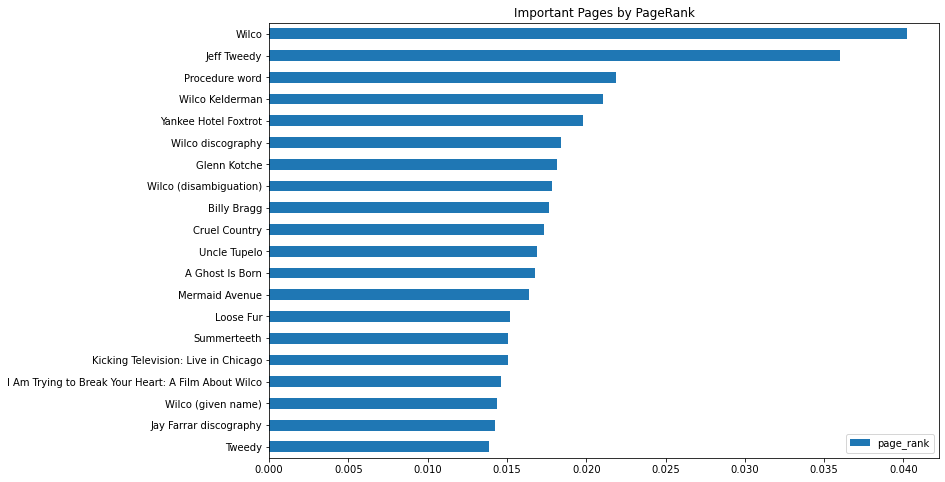

In [56]:
title = 'Important Pages by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

This hints at the mixed nature of this network. I can see that Wilco and Jeff Tweedy (lead singer of Wilco) have a drastically higher Page Rank score than the other nodes.

In [59]:
betw_cent = nx.betweenness_centrality(G)

betw_cent_df = pd.DataFrame().from_dict(betw_cent, orient='index')
betw_cent_df.columns = ['betweenness_centrality']
betw_cent_df.sort_values('betweenness_centrality', ascending=False, inplace=True)
betw_cent_df.head(10)

,betweenness_centrality
Wilco,0.548412
Jeff Tweedy,0.157398
Procedure word,0.128628
Wilco Kelderman,0.106282
Space Quest,0.082909
A Ghost Is Born,0.073075
Cruel Country,0.071813
Billy Bragg,0.071160
Loose Fur,0.059985
Wilco (disambiguation),0.057518


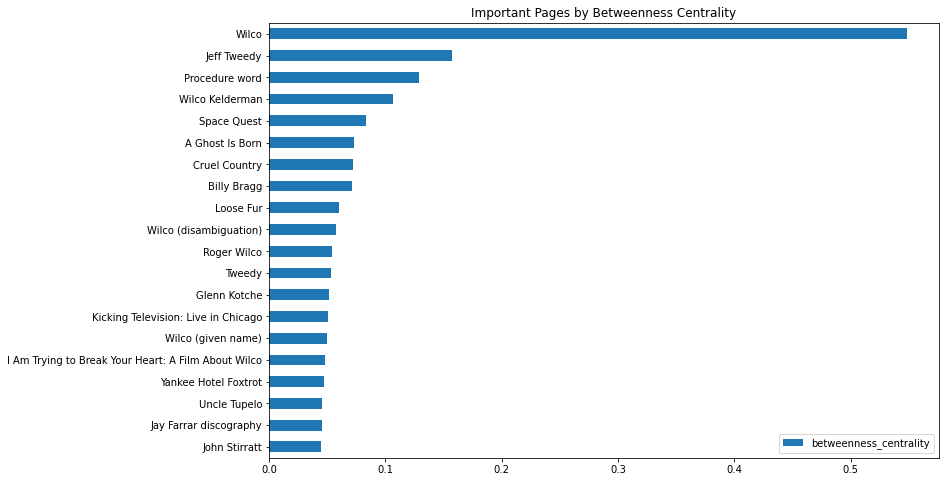

In [60]:
title = 'Important Pages by Betweenness Centrality'

betw_cent_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Jeff Tweedy, Billy Bragg, Roger Wilco, Tweedy, Glenn Kotche, Jay Farrar, Uncle Tupelo, John Stirratt - Who/What are they?

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [61]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [62]:
# identify communities; set resolution to 0.01 for smaller groups and 1 for larger groups, etc
# play with the number to get communities to the size you want them, or leave it at the default

partition = community_louvain.best_partition(G, resolution=0.5, random_state=1337) 

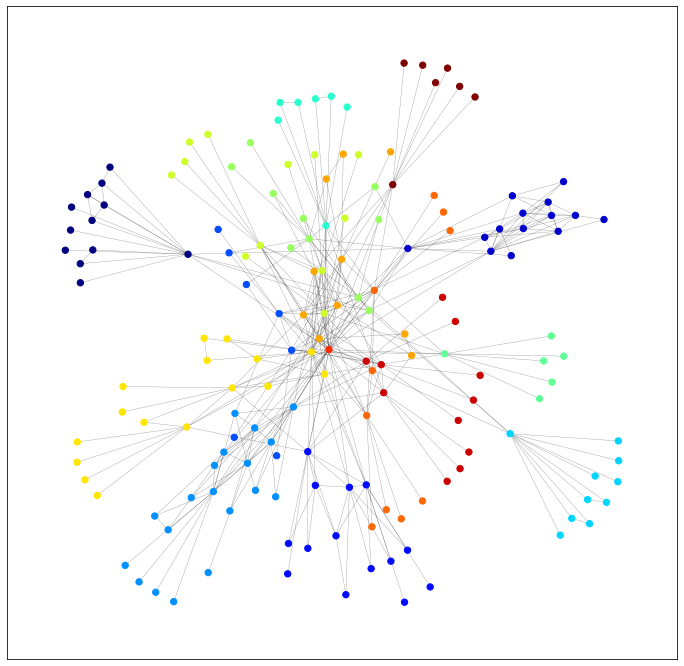

In [65]:
draw_partition(G, partition)

In [66]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

4     19
10    16
1     14
2     14
0     12
9     12
14    11
5     10
11    10
12    10
8     10
6      7
15     7
3      7
7      6
13     1
Name: community, dtype: int64

In [67]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([ 4, 10,  1,  2,  0,  9, 14,  5, 11, 12,  8,  6, 15,  3,  7, 13],
      dtype=int64)

## Exploring Communities
Below, I am showing the largest community in the network. Looking at some of the node labels, I can see many instances of the word "graph". We are in the right place. 

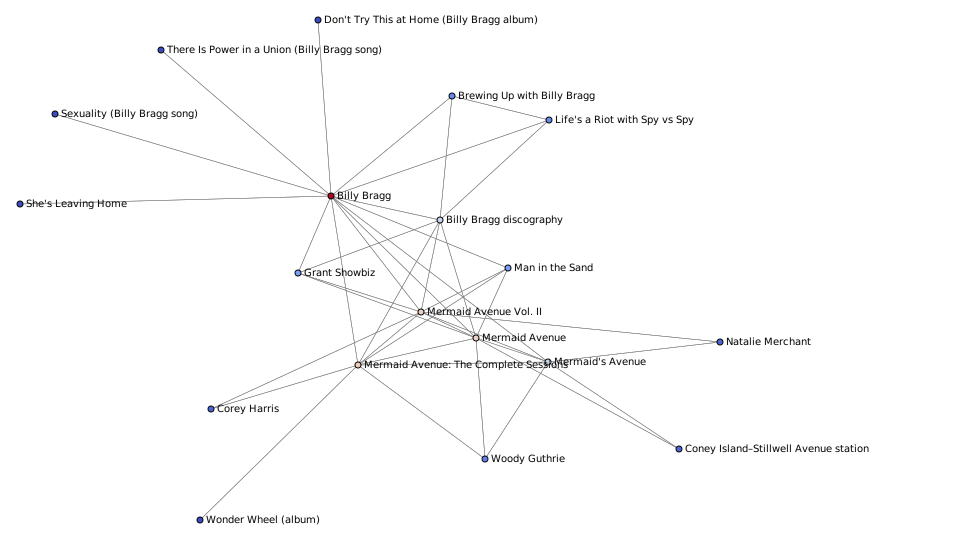

In [69]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [70]:
netsci_nodes = [n for n in sorted(G_net_main.nodes)]
[print(n) for n in netsci_nodes]

Billy Bragg
Billy Bragg discography
Brewing Up with Billy Bragg
Coney Island–Stillwell Avenue station
Corey Harris
Don't Try This at Home (Billy Bragg album)
Grant Showbiz
Life's a Riot with Spy vs Spy
Man in the Sand
Mermaid Avenue
Mermaid Avenue Vol. II
Mermaid Avenue: The Complete Sessions
Mermaid's Avenue
Natalie Merchant
Sexuality (Billy Bragg song)
She's Leaving Home
There Is Power in a Union (Billy Bragg song)
Wonder Wheel (album)
Woody Guthrie


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## More Communities!

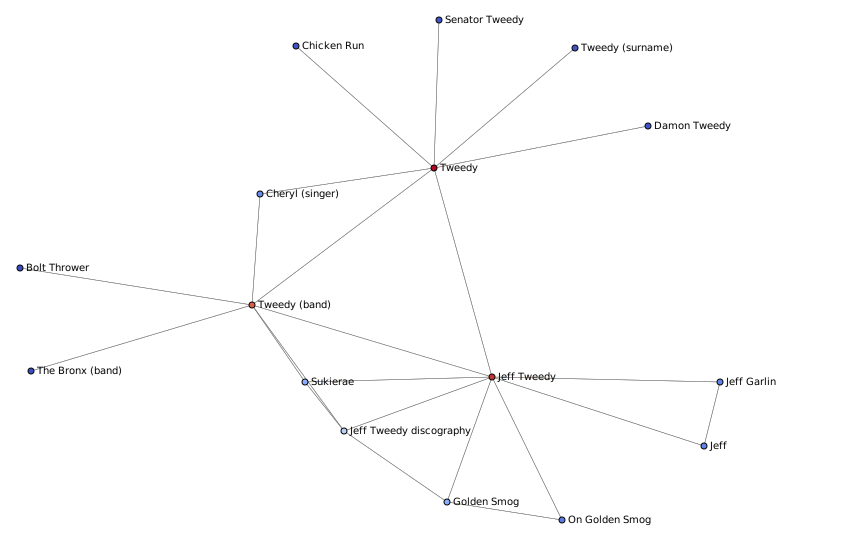

In [71]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [72]:
[print(n) for n in sorted(G_comm.nodes)]

Bolt Thrower
Cheryl (singer)
Chicken Run
Damon Tweedy
Golden Smog
Jeff
Jeff Garlin
Jeff Tweedy
Jeff Tweedy discography
On Golden Smog
Senator Tweedy
Sukierae
The Bronx (band)
Tweedy
Tweedy (band)
Tweedy (surname)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

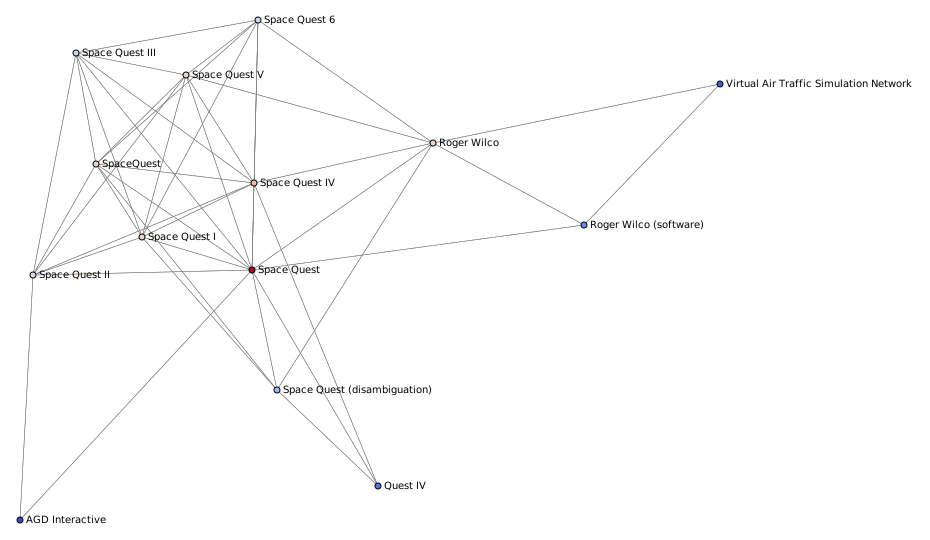

In [73]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [74]:
[print(n) for n in sorted(G_comm.nodes)]

AGD Interactive
Quest IV
Roger Wilco
Roger Wilco (software)
Space Quest
Space Quest (disambiguation)
Space Quest 6
Space Quest I
Space Quest II
Space Quest III
Space Quest IV
Space Quest V
SpaceQuest
Virtual Air Traffic Simulation Network


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

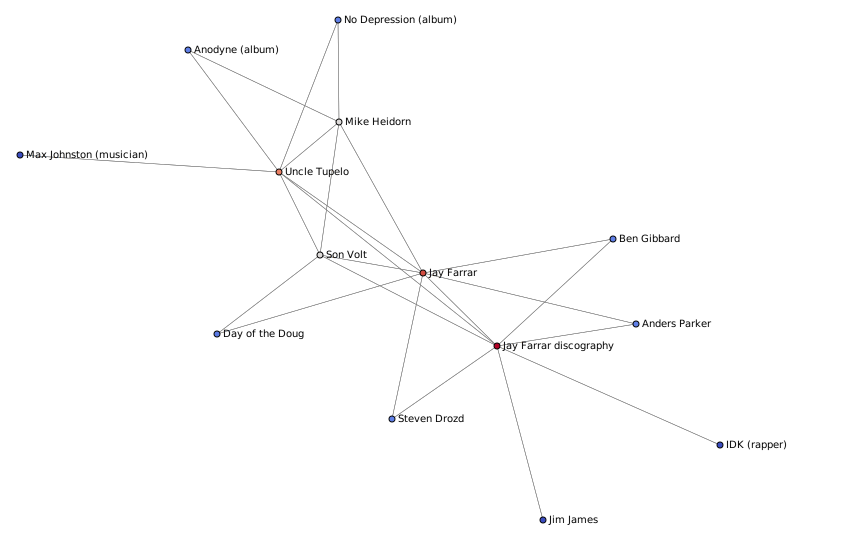

In [114]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [76]:
[print(n) for n in sorted(G_comm.nodes)]

Anders Parker
Anodyne (album)
Ben Gibbard
Day of the Doug
IDK (rapper)
Jay Farrar
Jay Farrar discography
Jim James
Max Johnston (musician)
Mike Heidorn
No Depression (album)
Son Volt
Steven Drozd
Uncle Tupelo


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

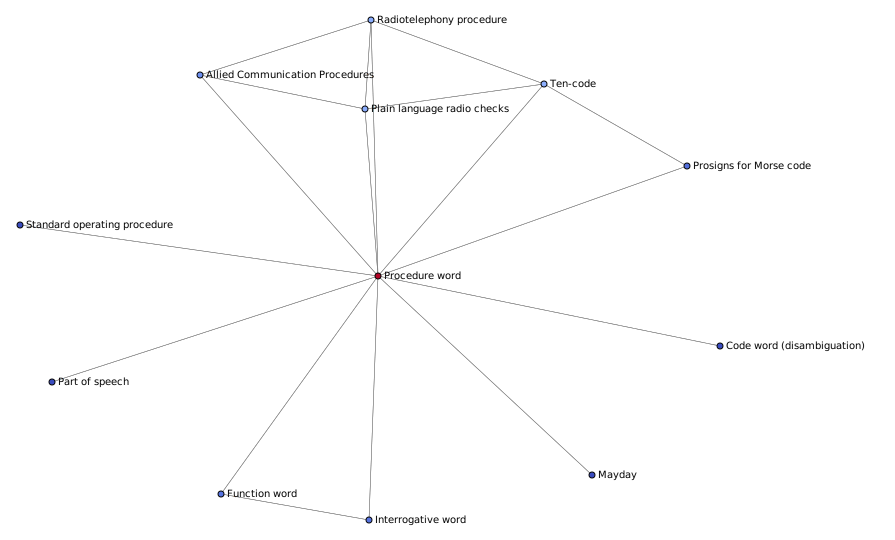

In [77]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [78]:
[print(n) for n in sorted(G_comm.nodes)]

Allied Communication Procedures
Code word (disambiguation)
Function word
Interrogative word
Mayday
Part of speech
Plain language radio checks
Procedure word
Prosigns for Morse code
Radiotelephony procedure
Standard operating procedure
Ten-code


[None, None, None, None, None, None, None, None, None, None, None, None]

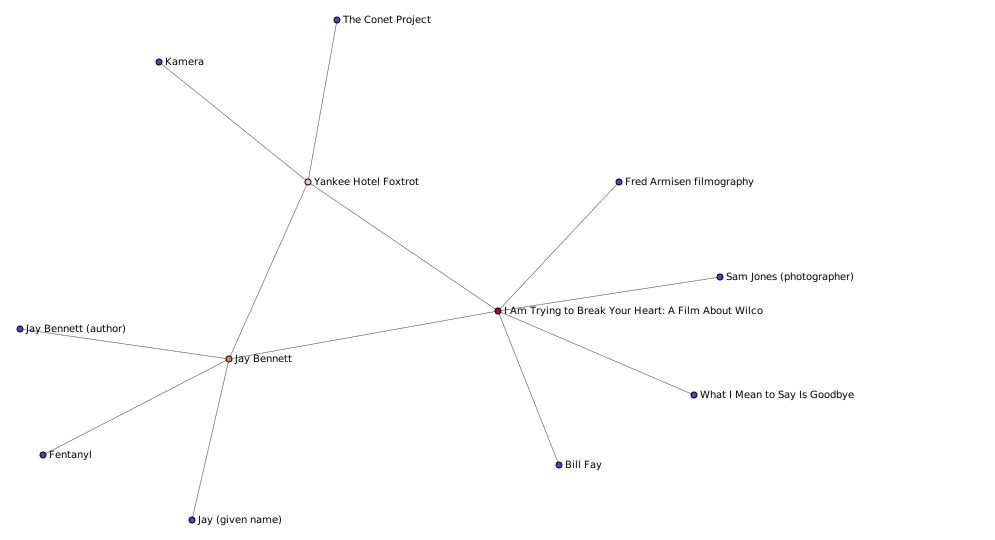

In [79]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [80]:
[print(n) for n in sorted(G_comm.nodes)]

Bill Fay
Fentanyl
Fred Armisen filmography
I Am Trying to Break Your Heart: A Film About Wilco
Jay (given name)
Jay Bennett
Jay Bennett (author)
Kamera
Sam Jones (photographer)
The Conet Project
What I Mean to Say Is Goodbye
Yankee Hotel Foxtrot


[None, None, None, None, None, None, None, None, None, None, None, None]

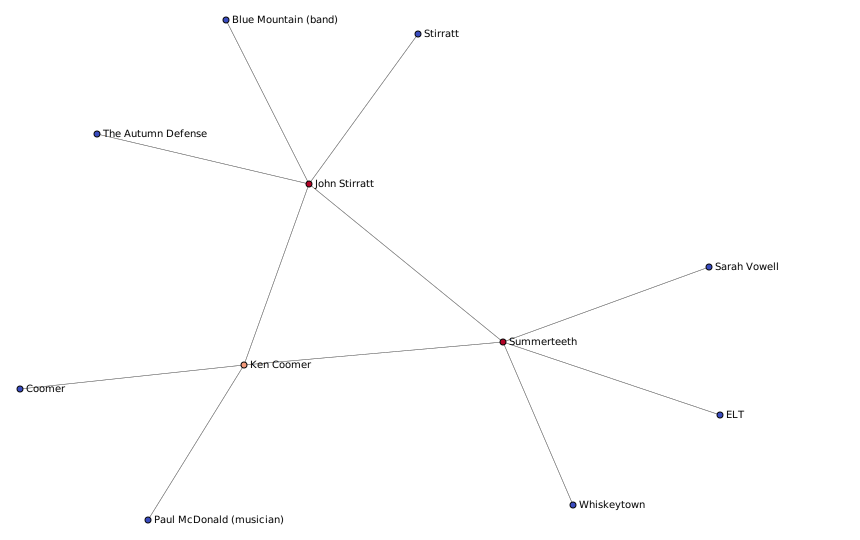

In [81]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [82]:
[print(n) for n in sorted(G_comm.nodes)]

Blue Mountain (band)
Coomer
ELT
John Stirratt
Ken Coomer
Paul McDonald (musician)
Sarah Vowell
Stirratt
Summerteeth
The Autumn Defense
Whiskeytown


[None, None, None, None, None, None, None, None, None, None, None]

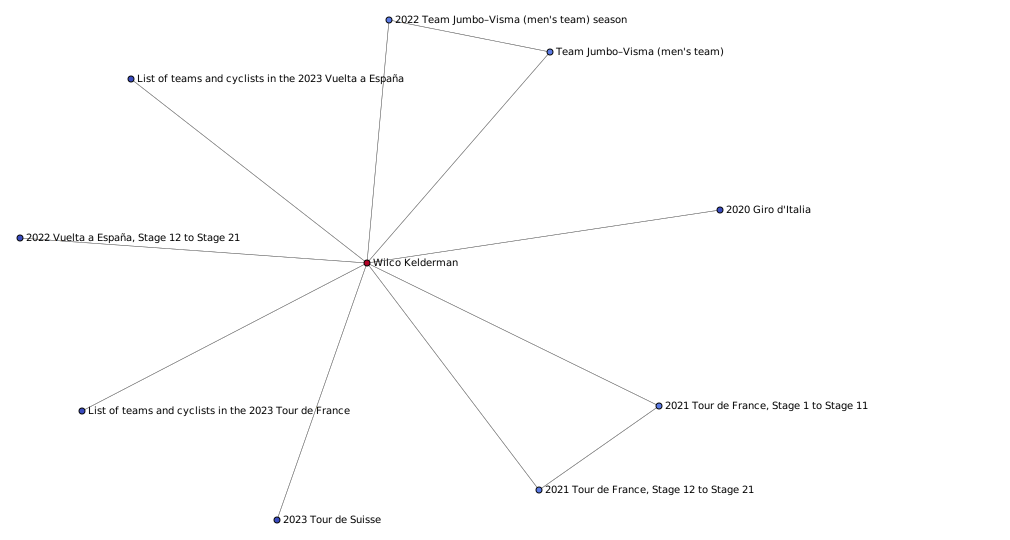

In [83]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [84]:
[print(n) for n in sorted(G_comm.nodes)]

2020 Giro d'Italia
2021 Tour de France, Stage 1 to Stage 11
2021 Tour de France, Stage 12 to Stage 21
2022 Team Jumbo–Visma (men's team) season
2022 Vuelta a España, Stage 12 to Stage 21
2023 Tour de Suisse
List of teams and cyclists in the 2023 Tour de France
List of teams and cyclists in the 2023 Vuelta a España
Team Jumbo–Visma (men's team)
Wilco Kelderman


[None, None, None, None, None, None, None, None, None, None]

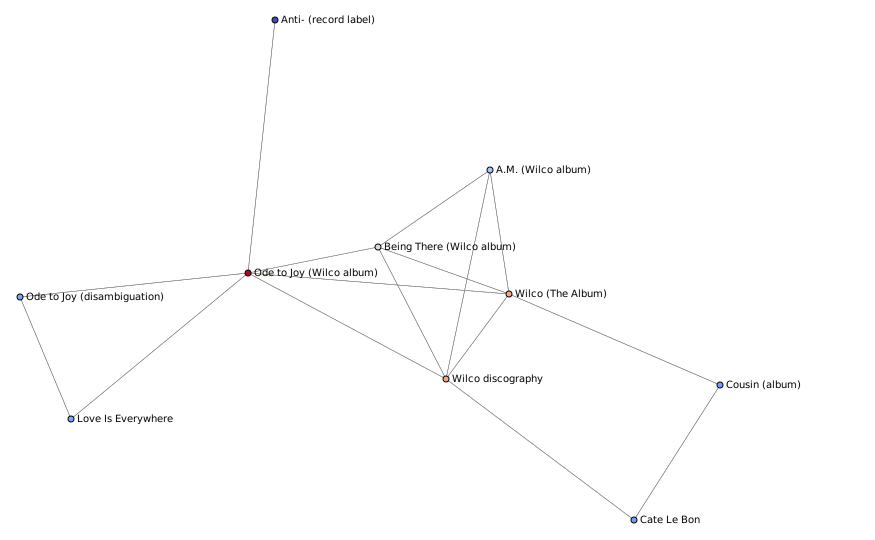

In [85]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [86]:
[print(n) for n in sorted(G_comm.nodes)]

A.M. (Wilco album)
Anti- (record label)
Being There (Wilco album)
Cate Le Bon
Cousin (album)
Love Is Everywhere
Ode to Joy (Wilco album)
Ode to Joy (disambiguation)
Wilco (The Album)
Wilco discography


[None, None, None, None, None, None, None, None, None, None]

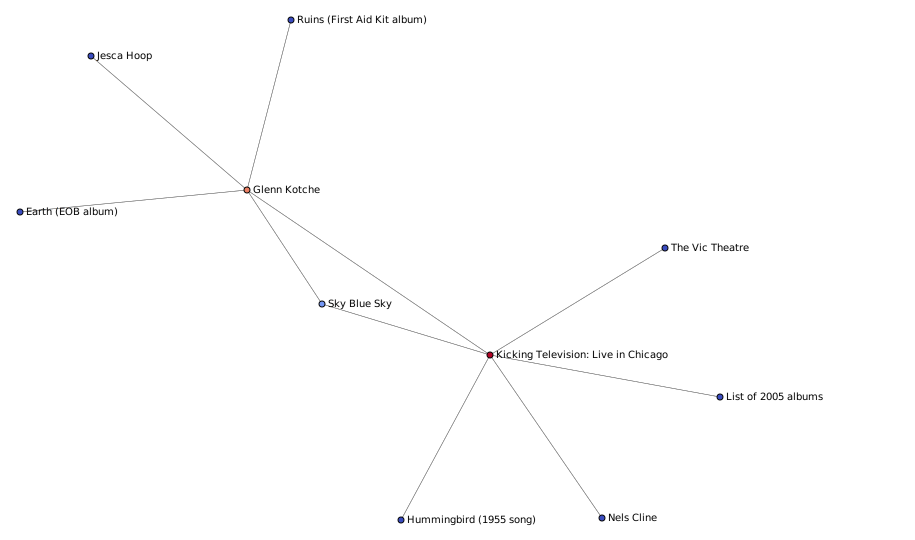

In [87]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

# Ego Networks

Ego Networks are very useful for seeing what nodes exists around a node of interest, and how they are connected. In this dataset, there is a lot of cross-linking from alter nodes (the outer nodes), so we have interesting ego networks to look at. This is not always the case, so it is nice.

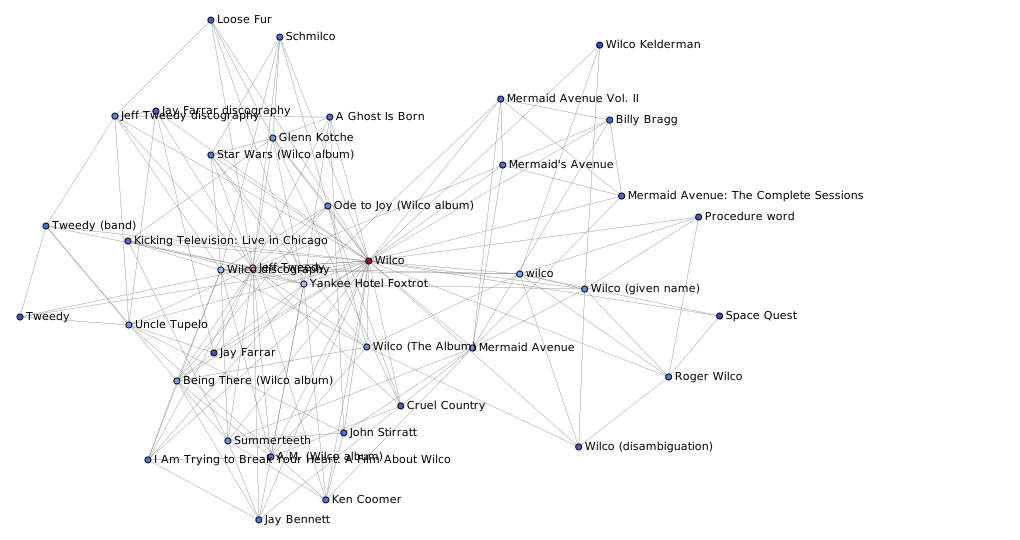

In [99]:
ego = nx.ego_graph(G, 'Wilco')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

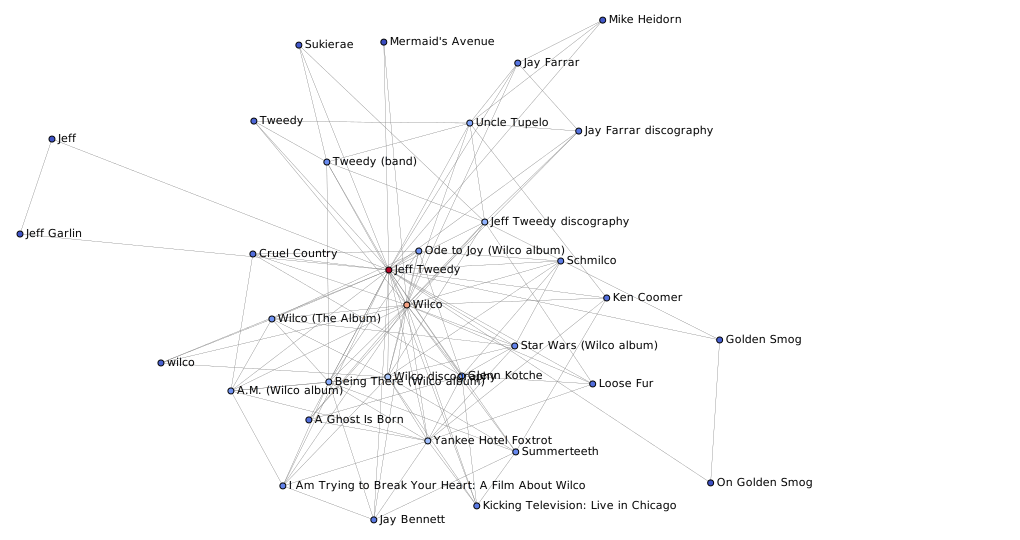

In [100]:
ego = nx.ego_graph(G, 'Jeff Tweedy')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

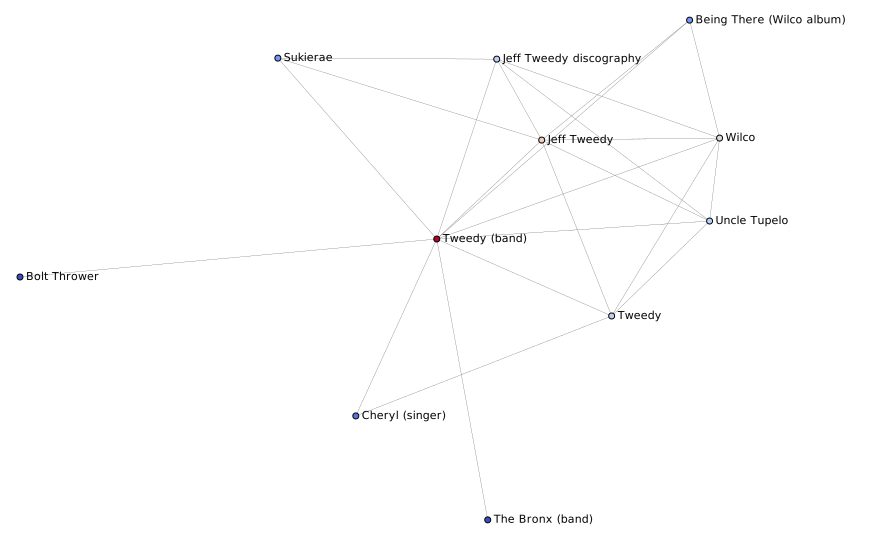

In [101]:
ego = nx.ego_graph(G, 'Tweedy (band)')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

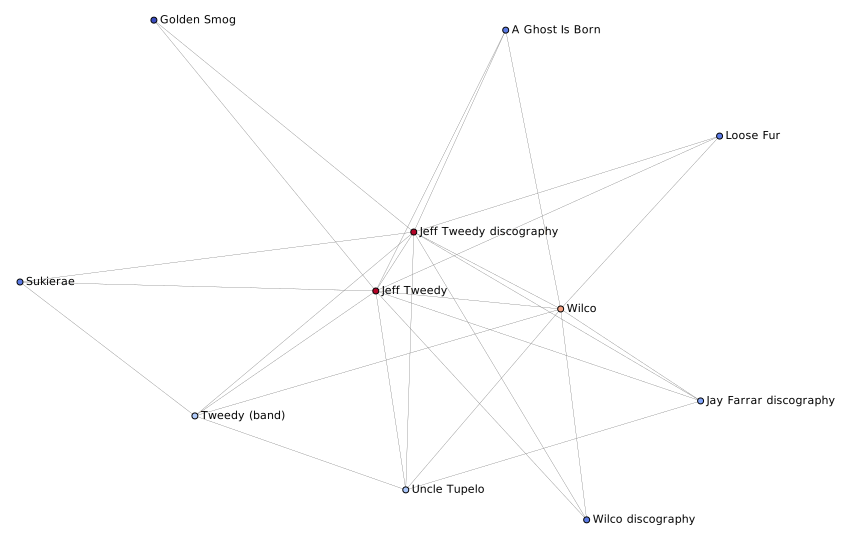

In [102]:
ego = nx.ego_graph(G, 'Jeff Tweedy discography')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

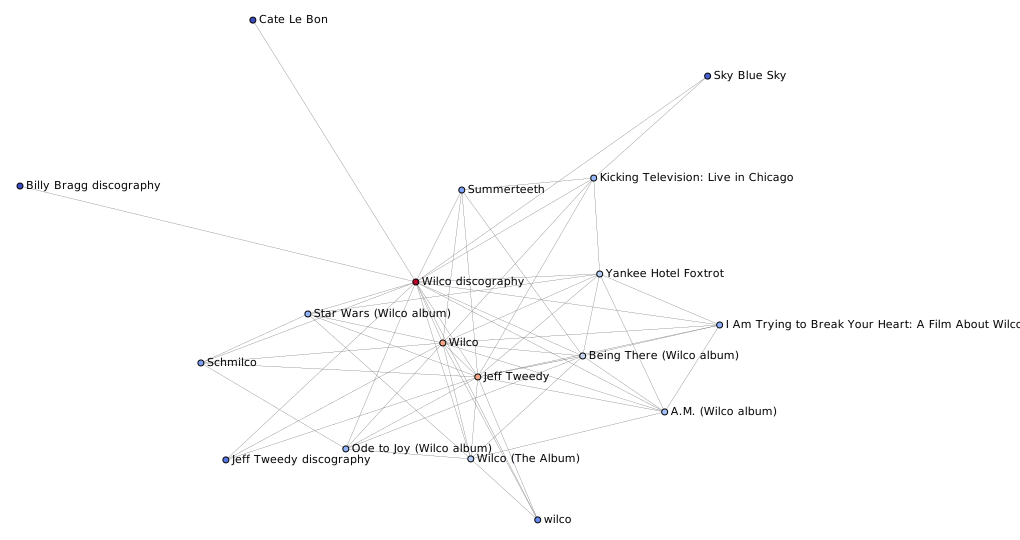

In [103]:
ego = nx.ego_graph(G, 'Wilco discography')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)